In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [2]:
df_train= pd.read_csv("/kaggle/input/playground-series-s5e11/train.csv")
df_test= pd.read_csv("/kaggle/input/playground-series-s5e11/test.csv")

In [3]:
# verbose=True: Sütun sayısı çoksa bile hepsini listelemesini sağlar
# null_counts=True: Boş değer sayılarını da gösterir
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


In [4]:
df_train_processed=df_train.copy()
df_train_processed['education_level'].unique()

array(['High School', "Master's", "Bachelor's", 'PhD', 'Other'],
      dtype=object)

In [5]:
#Mapping for education_level feature
education_map_dic= {'High School':1, "Master's":3, "Bachelor's":2, 'PhD':4, 'Other':0}

df_train_processed['education_level'] = df_train_processed['education_level'].map(education_map_dic)

#Buradan çıkarılan ders Label-encoder rastgele sayılar vericekti onun yerine mapping ile numara atamalarını yapmak daha mantıklı
#Çünkü ağırlık da önemli

#Mapping for grade_subgrade
ct=0
sorted_list=sorted(df_train_processed['grade_subgrade'].unique())
grade_map_dic={}

for i in sorted_list:    
    grade_map_dic[i]=ct
    ct+=1    
df_train_processed['grade_subgrade']=df_train_processed['grade_subgrade'].map(grade_map_dic)

df_train_processed['grade_subgrade'].head()


0    12
1    17
2    14
3    25
4    15
Name: grade_subgrade, dtype: int64

In [6]:
print(df_train_processed[['education_level', 'grade_subgrade']].dtypes)

education_level    int64
grade_subgrade     int64
dtype: object


In [7]:
obj_col_list=df_train_processed.select_dtypes(include=['object']).columns.tolist()
print(obj_col_list)
#drop_first true yapmadım önce bu şekilde eğiticem modellerimi
#eğer beklediğim performans olmazsa özellikle logistic regresyon tarafında ve elimde iyi
#model kalmazsa o zaman yeni bir yol düşünürüm veya vaktim kalırsa.

df_train_processed = pd.get_dummies(
df_train_processed,
columns=obj_col_list,
drop_first=False,
dtype=int,
)
df_train_processed.info(verbose=True)

['gender', 'marital_status', 'employment_status', 'loan_purpose']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 29 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   id                               593994 non-null  int64  
 1   annual_income                    593994 non-null  float64
 2   debt_to_income_ratio             593994 non-null  float64
 3   credit_score                     593994 non-null  int64  
 4   loan_amount                      593994 non-null  float64
 5   interest_rate                    593994 non-null  float64
 6   education_level                  593994 non-null  int64  
 7   grade_subgrade                   593994 non-null  int64  
 8   loan_paid_back                   593994 non-null  float64
 9   gender_Female                    593994 non-null  int64  
 10  gender_Male                      593994 non-null  int64  
 11 

# Model karşılaştırması

In [8]:

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier 


models = {
    # Boosting
    "XGBoost": xgb.XGBClassifier(n_jobs=-1, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": lgb.LGBMClassifier(n_jobs=-1, verbose=-1), 
    "CatBoost": CatBoostClassifier(verbose=0, thread_count=-1),
    "AdaBoost": AdaBoostClassifier(n_estimators=50),
    
    # Bagging / Ensemble Ailesi
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, n_jobs=-1),
    "Bagging": BaggingClassifier(n_jobs=-1),
    
    # Temel Modeller 
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "Naive Bayes": GaussianNB(),

    "KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1), 
    "SVM (Linear)": LinearSVC(dual=False, random_state=42), 
}

In [10]:
X_train=df_train_processed.drop(columns=['id','loan_paid_back']).to_numpy()
y_train=df_train_processed['loan_paid_back'].astype(int).to_numpy()
X_test = df_test.drop('id',axis=1).to_numpy()


In [10]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import time
import pickle

best_model = None
best_model_name = None
best_score = 0

"""ya berkay neden df_train verisinin train_test_split kullanmadın validation verin yok... çünkü croos val
bunu yapıyor zaten kendisi valıdation oluşturuyor.aldığı parametrelerden de aşikar olman lazım.

bunu neden yazıyorum train_test_split yapmış gibi davanma koda.
geçmiş kodunda bir tane data leak problemiyle karşılaştın scale olmuş bir veriyi
x_train_mm olarak direkt verdin ama cross val verini parçalara ayırırken test verin min_max_scaling 
işleminden zaten geçip bir şeyleri fit_transform ederek işlemi yapmıştı.
kod anında cross val içindeki ayrımda x_trainin fit_transform edilirken ondan ayrılan validationda
transform olmasını istiyorsan pipeline içinde yap"""

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f" Model Eğitiliyor: {name}...")
    start_time = time.time()
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)
    end_time = time.time()
    mean_score = scores.mean()
    
    print(f" {name} -> Mean ROC-AUC: {mean_score:.4f} (Süre: {end_time - start_time:.2f} sn)")

    if mean_score > best_score:
        best_score = mean_score
        
        best_model = model
        best_model_name = name

print("\n" + "="*30)
print(f"Best MODEL: {best_model_name}")
print(f"SKOR (ROC-AUC): {best_score:.4f}")
print("="*30)




 Model Eğitiliyor: XGBoost...
 XGBoost -> Mean ROC-AUC: 0.9205 (Süre: 19.71 sn)
 Model Eğitiliyor: LightGBM...
 LightGBM -> Mean ROC-AUC: 0.9196 (Süre: 217.94 sn)
 Model Eğitiliyor: CatBoost...
 CatBoost -> Mean ROC-AUC: 0.9231 (Süre: 358.23 sn)
 Model Eğitiliyor: AdaBoost...


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


 AdaBoost -> Mean ROC-AUC: 0.9137 (Süre: 110.71 sn)
 Model Eğitiliyor: Random Forest...


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


 Random Forest -> Mean ROC-AUC: 0.9075 (Süre: 314.16 sn)
 Model Eğitiliyor: Extra Trees...
 Extra Trees -> Mean ROC-AUC: 0.9009 (Süre: 247.09 sn)
 Model Eğitiliyor: Bagging...
 Bagging -> Mean ROC-AUC: 0.8830 (Süre: 137.65 sn)
 Model Eğitiliyor: Decision Tree...
 Decision Tree -> Mean ROC-AUC: 0.7723 (Süre: 22.60 sn)
 Model Eğitiliyor: Logistic Regression...
 Logistic Regression -> Mean ROC-AUC: 0.7339 (Süre: 6.73 sn)
 Model Eğitiliyor: Naive Bayes...
 Naive Bayes -> Mean ROC-AUC: 0.7690 (Süre: 1.72 sn)
 Model Eğitiliyor: KNN...
 KNN -> Mean ROC-AUC: 0.5613 (Süre: 930.16 sn)
 Model Eğitiliyor: SVM (Linear)...
 SVM (Linear) -> Mean ROC-AUC: 0.7638 (Süre: 9.11 sn)

Best MODEL: CatBoost
SKOR (ROC-AUC): 0.9231


# Feature keşfi


In [11]:
def create_new_features(df):
    # 1. Loan to Income
    #df['loan_to_income'] = df['loan_amount'] / (df['annual_income'] + 1)

    # 2. Tahmini Mevcut Borç gelirle borç/geliri çarpıp borcuna bakıyoruz
    #df['existing_debt_amount'] = df['annual_income'] * df['debt_to_income_ratio']

    # 4. Faiz Yükü
    #df['interest_burden'] = df['loan_amount'] * df['interest_rate']

    # 5. Risk Oranı
    df['loan_to_score_ratio'] = df['loan_amount'] / (df['credit_score'] + 1)

    return df

In [12]:

df_train_featured = df_train_processed.copy()
df_test_featured = df_test.copy()
print("Feature Engineering Uygulanıyor...")
df_train_featured = create_new_features(df_train_featured)
df_train_featured.info(verbose=True)


Feature Engineering Uygulanıyor...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 30 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   id                               593994 non-null  int64  
 1   annual_income                    593994 non-null  float64
 2   debt_to_income_ratio             593994 non-null  float64
 3   credit_score                     593994 non-null  int64  
 4   loan_amount                      593994 non-null  float64
 5   interest_rate                    593994 non-null  float64
 6   education_level                  593994 non-null  int64  
 7   grade_subgrade                   593994 non-null  int64  
 8   loan_paid_back                   593994 non-null  float64
 9   gender_Female                    593994 non-null  int64  
 10  gender_Male                      593994 non-null  int64  
 11  gender_Other                  

In [13]:
X_featured=df_train_featured.drop(columns=['id','loan_paid_back']).to_numpy()
y_featured=df_train_featured['loan_paid_back'].astype(int).to_numpy()

In [11]:
selected_models={
    "XGBoost": xgb.XGBClassifier(n_jobs=-1, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": lgb.LGBMClassifier(n_jobs=-1, verbose=-1), 
    "CatBoost": CatBoostClassifier(verbose=0, thread_count=-1),
}

In [15]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
import time
import pickle

best_model = None
best_model_name = None
best_score = 0

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in selected_models.items():
    print(f" Model Eğitiliyor: {name}...")
    start_time = time.time()
    scores = cross_val_score(model, X_featured, y_featured, cv=skf, scoring='roc_auc', n_jobs=-1)
    end_time = time.time()
    mean_score = scores.mean()
    
    print(f" {name} -> Mean ROC-AUC: {mean_score:.6f} (Süre: {end_time - start_time:.2f} sn)")

    if mean_score > best_score:
        best_score = mean_score
        
        best_model = model
        best_model_name = name

print("\n" + "="*30)
print(f"Best MODEL: {best_model_name}")
print(f"SKOR (ROC-AUC): {best_score:.4f}")
print("="*30)




 Model Eğitiliyor: XGBoost...
 XGBoost -> Mean ROC-AUC: 0.920459 (Süre: 18.98 sn)
 Model Eğitiliyor: LightGBM...
 LightGBM -> Mean ROC-AUC: 0.919569 (Süre: 219.94 sn)
 Model Eğitiliyor: CatBoost...


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


 CatBoost -> Mean ROC-AUC: 0.922968 (Süre: 369.92 sn)

Best MODEL: CatBoost
SKOR (ROC-AUC): 0.9230


# Featureların birbiriyle ilişkisi keşfi zarara uğrattı best model için. 
# catboost ham veri istese de scale etmek istiyorum.

In [16]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.pipeline import Pipeline

scenarios= {
    "raw": None,
    "Min-Max":MinMaxScaler(),
    "Standard":StandardScaler()
}


model_cat=CatBoostClassifier(verbose=0,thread_count=-1,random_seed=42)
skf=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)#döngünün dışına aldım çünkü fordayken her seferinde yeni bir skf nesnesi oluştursun istemedim

results=[]

for scaler_name,scaler in scenarios.items():
    start_time=time.time()
    if scaler is None:
        estimator=model_cat
    else:
        estimator = Pipeline([
            ('scaler',scaler),
            ('model',model_cat)
        ])
    scores=cross_val_score(estimator,X_train,y_train, cv=skf,scoring='roc_auc',n_jobs=-1)
    end_time=time.time()
    mean_score=scores.mean()
    std_score=scores.std()
    print(f"{scaler_name:<20} -> AUC: {mean_score:.6f} (+/- {std_score:.5f}) | Süre: {end_time - start_time:.2f} sn")
    
    results.append({'Senaryo': scaler_name, 'AUC': mean_score})
print("\n--- SONUÇ ANALİZİ ---")
df_res = pd.DataFrame(results).sort_values(by='AUC', ascending=False)
print(df_res)

raw                  -> AUC: 0.923046 (+/- 0.00073) | Süre: 362.05 sn
Min-Max              -> AUC: 0.923048 (+/- 0.00074) | Süre: 359.09 sn
Standard             -> AUC: 0.923031 (+/- 0.00079) | Süre: 358.46 sn

--- SONUÇ ANALİZİ ---
    Senaryo       AUC
1   Min-Max  0.923048
0       raw  0.923046
2  Standard  0.923031


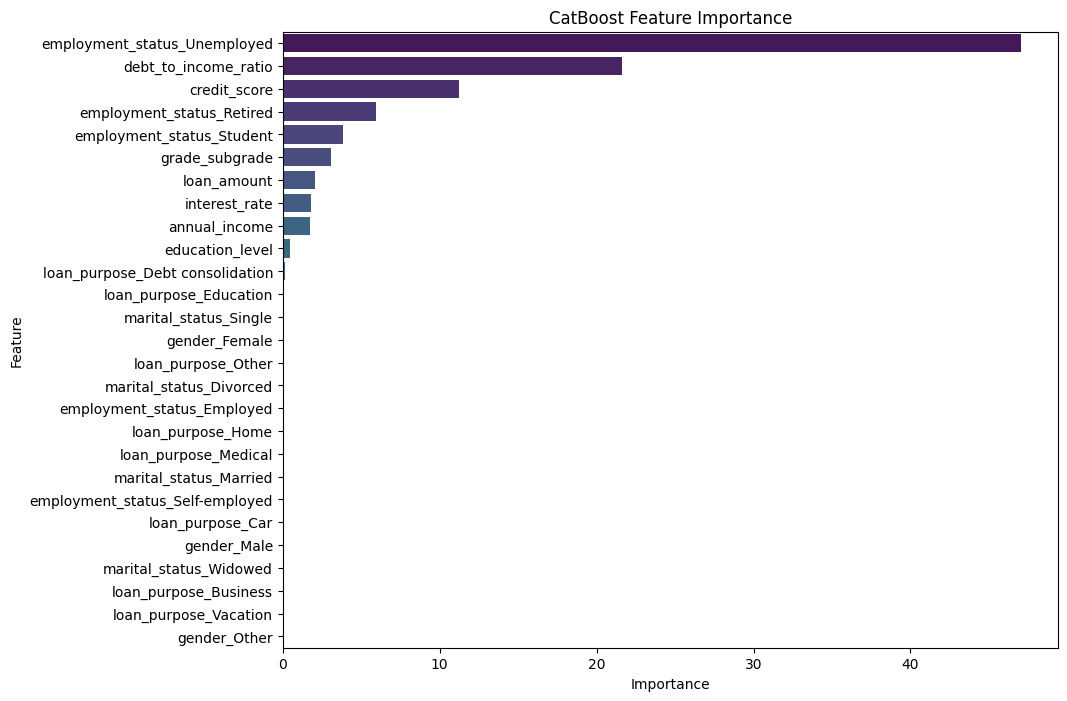

                         Feature  Importance
18  employment_status_Unemployed   47.036035
1           debt_to_income_ratio   21.639782
2                   credit_score   11.212634
15     employment_status_Retired    5.953914
17     employment_status_Student    3.808715
6                 grade_subgrade    3.103805
3                    loan_amount    2.035458
4                  interest_rate    1.810821
0                  annual_income    1.759785
5                education_level    0.439211


In [36]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from catboost import CatBoostClassifier

model_cat=CatBoostClassifier(verbose=0,thread_count=-1)
model_cat.fit(X_train, y_train)

importance = model_cat.get_feature_importance()

# Sütun isimlerini df_train_processed'dan geri çağıralım (X numpy olduğu için isimler yoktu)
# Eğer elinde feature_names listesi varsa onu kullan. Yoksa şuradan üret:
feature_names = df_train_processed.drop(columns=['id', 'loan_paid_back']).columns.tolist()

# 5. Görselleştirme (DataFrame Yapısı)
df_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

# İlk 20 özelliği çizdir
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=df_imp.head(28), palette='viridis')
plt.title('CatBoost Feature Importance')
plt.show()

# Sayısal olarak görmek istersen:
print(df_imp.head(10))

# GRID SEARCH YERINE OPTUNA DENEYIMLEDIM

In [21]:
#optunadan gelen en iyi parametrelerim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, 
                             classification_report, confusion_matrix, roc_curve)
from catboost import CatBoostClassifier

best_params = {
    'iterations': 1565,
    'learning_rate': 0.12352617617825368,
    'depth': 4,
    'l2_leaf_reg': 4.166838905969808,
    'border_count': 247,
    'random_strength': 8.677760209459985e-07,
    'bagging_temperature': 0.15688835642328666,
    
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'verbose': 100,
    'random_seed': 42
}

In [22]:
X_train_last,X_test_last,y_train_last,y_test_last=train_test_split(X_train,y_train,test_size=0.2,stratify=y_train,random_state=42)

model_last=CatBoostClassifier(**best_params)

model_last.fit(X_train_last,y_train_last)
y_pred=model_last.predict(X_test_last)
y_prob=model_last.predict_proba(X_test_last)[:, 1]


0:	total: 111ms	remaining: 2m 52s
100:	total: 4.43s	remaining: 1m 4s
200:	total: 8.66s	remaining: 58.8s
300:	total: 13s	remaining: 54.4s
400:	total: 17.3s	remaining: 50.3s
500:	total: 21.6s	remaining: 46s
600:	total: 26.1s	remaining: 41.8s
700:	total: 30.5s	remaining: 37.6s
800:	total: 35s	remaining: 33.3s
900:	total: 39.4s	remaining: 29s
1000:	total: 43.8s	remaining: 24.7s
1100:	total: 48.2s	remaining: 20.3s
1200:	total: 52.6s	remaining: 15.9s
1300:	total: 57.1s	remaining: 11.6s
1400:	total: 1m 1s	remaining: 7.2s
1500:	total: 1m 6s	remaining: 2.82s
1564:	total: 1m 8s	remaining: 0us


In [23]:
acc=accuracy_score(y_test_last,y_pred)
auc=roc_auc_score(y_test_last,y_prob)
print(f" Accuracy (Doğruluk):  %{acc*100:.2f}")
print(f" ROC-AUC Skoru:        {auc:.5f}")
print("Classification Report:\n")
print(classification_report(y_test_last, y_pred))

 Accuracy (Doğruluk):  %90.66
 ROC-AUC Skoru:        0.92315
Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.62      0.73     23900
           1       0.91      0.98      0.94     94899

    accuracy                           0.91    118799
   macro avg       0.89      0.80      0.84    118799
weighted avg       0.90      0.91      0.90    118799



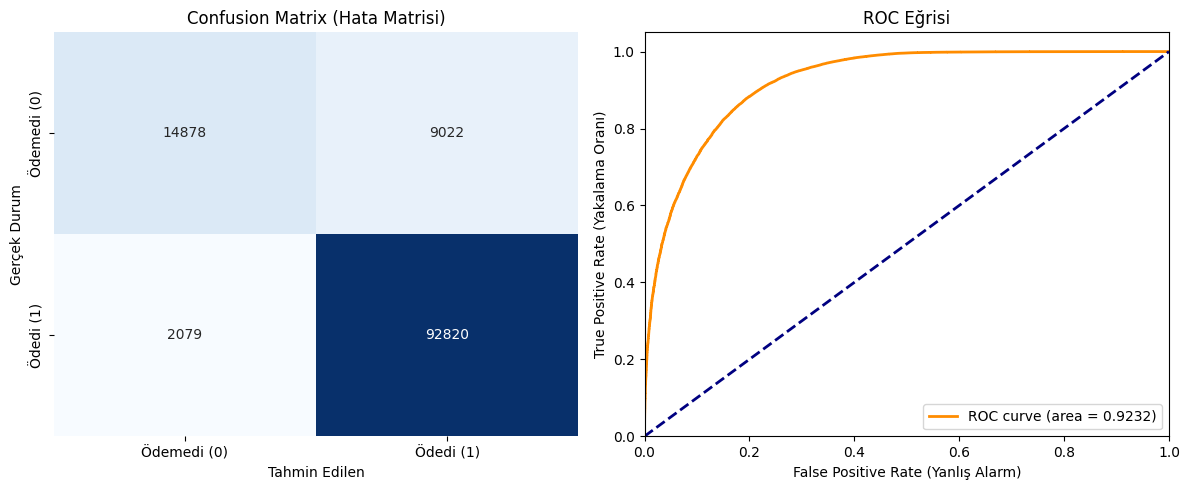

In [24]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test_last, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Ödemedi (0)', 'Ödedi (1)'],
            yticklabels=['Ödemedi (0)', 'Ödedi (1)'])
plt.title("Confusion Matrix (Hata Matrisi)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Durum")

# ======================================================
# 6. Görselleştirme: ROC Eğrisi
# ======================================================
plt.subplot(1, 2, 2)
fpr, tpr, thresholds = roc_curve(y_test_last, y_prob)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Rastgele tahmin çizgisi
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Yanlış Alarm)')
plt.ylabel('True Positive Rate (Yakalama Oranı)')
plt.title('ROC Eğrisi')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

# MODEL eşik değerini 0.7 yapmak daha karlı

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, classification_report

# 1. Eğriyi Oluştur
precisions, recalls, thresholds = precision_recall_curve(y_test_last, y_prob)

# Precision ve Recall dizilerinin son elemanını atıyoruz ki Thresholds ile aynı boyda olsunlar.
precisions_aligned = precisions[:-1]
recalls_aligned = recalls[:-1]

# 2. Hedef Denge Noktası (F1 Score'u maksimize eden nokta gibidir)
# Precision ve Recall'un birbirine en yakın olduğu (kesiştiği) yer
optimal_idx = np.argmax(np.abs(precisions_aligned - recalls_aligned) * -1) # Farkı minimize, benzerliği maksimize
# Veya F1 skorunu maksimize eden nokta:
# fscore = (2 * precisions_aligned * recalls_aligned) / (precisions_aligned + recalls_aligned)
# optimal_idx = np.argmax(fscore)

optimal_threshold = thresholds[optimal_idx]

print(f"⚖️ Denge Eşik Değeri: {optimal_threshold:.4f}")
print(f"   -> Bu noktada Precision: {precisions_aligned[optimal_idx]:.4f}")
print(f"   -> Bu noktada Recall:    {recalls_aligned[optimal_idx]:.4f}")

# 3. Yeni Eşik ile Tahmin Yap
y_pred_tuned = (y_prob >= optimal_threshold).astype(int)

print("\n📊 YENİ RAPOR (Eşik Ayarlı):")
print(classification_report(y_test_last, y_pred_tuned))

⚖️ Denge Eşik Değeri: 0.7079
   -> Bu noktada Precision: 0.9337
   -> Bu noktada Recall:    0.9337

📊 YENİ RAPOR (Eşik Ayarlı):
              precision    recall  f1-score   support

           0       0.74      0.74      0.74     23900
           1       0.93      0.93      0.93     94899

    accuracy                           0.89    118799
   macro avg       0.84      0.84      0.84    118799
weighted avg       0.89      0.89      0.89    118799



In [26]:
# Threshold ne olursa olsun, AUC soft prediction (y_prob) üzerinden hesaplanır
auc_score = roc_auc_score(y_test_last, y_prob)
print(f"Değişmeyen ROC-AUC Skoru: {auc_score:.5f}")

Değişmeyen ROC-AUC Skoru: 0.92315


Text(120.26909722222221, 0.5, 'Gerçek Durum')

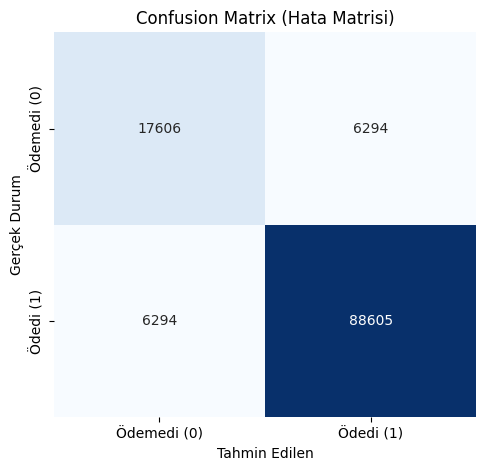

In [27]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test_last, y_pred_tuned)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Ödemedi (0)', 'Ödedi (1)'],
            yticklabels=['Ödemedi (0)', 'Ödedi (1)'])
plt.title("Confusion Matrix (Hata Matrisi)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Durum")



# Ensemble learning denemes 3 tane ağaç olması bir şeyi değiştirir mi değiştirmez mi?


328.26245379447937
 Accuracy (Doğruluk):  %90.59
 ROC-AUC Skoru:        0.92229
Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.64      0.73     23900
           1       0.91      0.97      0.94     94899

    accuracy                           0.91    118799
   macro avg       0.89      0.80      0.84    118799
weighted avg       0.90      0.91      0.90    118799



Text(120.26909722222221, 0.5, 'Gerçek Durum')

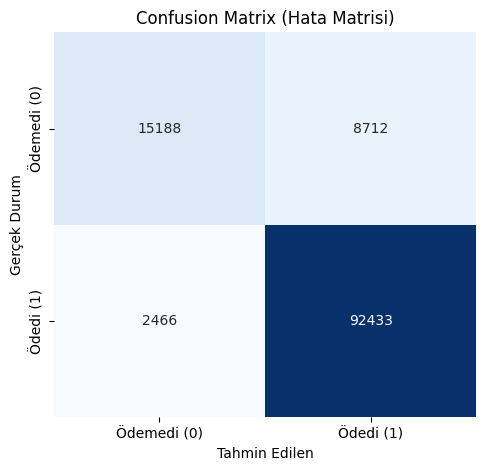

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,roc_auc_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import StackingClassifier

X_train_ensemble,X_test_ensemble,y_train_ensemble,y_test_ensemble=train_test_split(X_train,y_train,test_size=0.2,stratify=y_train,random_state=42)
estimators = list(selected_models.items())

patron_model = LogisticRegression(max_iter=1000) 

stacking_model = StackingClassifier(
    estimators=estimators,          
    final_estimator=patron_model,   
    cv=5,                                                               
    n_jobs=-1                       
)
start_time=time.time()
stacking_model.fit(X_train_ensemble,y_train_ensemble)
end_time=time.time()

print(end_time-start_time)

y_pred=stacking_model.predict(X_test_ensemble)
y_prob=stacking_model.predict_proba(X_test_ensemble)[:, 1]

acc=accuracy_score(y_test_ensemble,y_pred)
auc=roc_auc_score(y_test_ensemble,y_prob)
print(f" Accuracy (Doğruluk):  %{acc*100:.2f}")
print(f" ROC-AUC Skoru:        {auc:.5f}")
print("Classification Report:\n")
print(classification_report(y_test_ensemble, y_pred))


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test_ensemble, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Ödemedi (0)', 'Ödedi (1)'],
            yticklabels=['Ödemedi (0)', 'Ödedi (1)'])
plt.title("Confusion Matrix (Hata Matrisi)")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Durum")



# tüm veri ile eğitim

In [30]:

train_cols=df_train_processed.drop(columns=['id','loan_paid_back']).columns.tolist()
df_test_processed=df_test.copy()

df_test_processed['education_level']=df_test_processed['education_level'].map(education_map_dic)

df_test_processed['grade_subgrade']=df_test_processed['grade_subgrade'].map(grade_map_dic)

obj_col_list=df_test_processed.select_dtypes(include=['object']).columns.tolist()
df_test_processed = pd.get_dummies(
df_test_processed,
columns=obj_col_list,
drop_first=False,
dtype=int,
)

df_test_processed = df_test_processed.reindex(columns=train_cols, fill_value=0)
df_test_processed.info(verbose=True)

X_test = df_test_processed.to_numpy()







<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254569 entries, 0 to 254568
Data columns (total 27 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   annual_income                    254569 non-null  float64
 1   debt_to_income_ratio             254569 non-null  float64
 2   credit_score                     254569 non-null  int64  
 3   loan_amount                      254569 non-null  float64
 4   interest_rate                    254569 non-null  float64
 5   education_level                  254569 non-null  int64  
 6   grade_subgrade                   254569 non-null  int64  
 7   gender_Female                    254569 non-null  int64  
 8   gender_Male                      254569 non-null  int64  
 9   gender_Other                     254569 non-null  int64  
 10  marital_status_Divorced          254569 non-null  int64  
 11  marital_status_Married           254569 non-null  int64  
 12  ma

In [32]:
import time
import pickle
model_sub=CatBoostClassifier(**best_params)
start_time=time.time()
model_sub.fit(X_train,y_train)
end_time=time.time()
print(f"Süre: {end_time-start_time}")
model_sub.predict(X_test)


0:	total: 60.6ms	remaining: 1m 34s
100:	total: 5.24s	remaining: 1m 15s
200:	total: 10.5s	remaining: 1m 11s
300:	total: 15.8s	remaining: 1m 6s
400:	total: 21.1s	remaining: 1m 1s
500:	total: 26.5s	remaining: 56.4s
600:	total: 31.9s	remaining: 51.2s
700:	total: 37.4s	remaining: 46s
800:	total: 42.7s	remaining: 40.7s
900:	total: 48.2s	remaining: 35.5s
1000:	total: 53.7s	remaining: 30.2s
1100:	total: 59.2s	remaining: 25s
1200:	total: 1m 4s	remaining: 19.6s
1300:	total: 1m 10s	remaining: 14.2s
1400:	total: 1m 15s	remaining: 8.86s
1500:	total: 1m 21s	remaining: 3.46s
1564:	total: 1m 24s	remaining: 0us
Süre: 85.27736186981201


array([1, 1, 0, ..., 1, 1, 1])

In [34]:
submission=model_sub.predict_proba(X_test)[:, 1]
submission_file=pd.read_csv("/kaggle/input/playground-series-s5e11/sample_submission.csv")
save_path="/kaggle/working/submission.csv"
save_file=submission_file.copy()
save_file['loan_paid_back']=submission
save_file.to_csv(save_path,index=False)

⏳ SHAP değerleri hesaplanıyor (Biraz sürebilir)...
📊 SHAP Summary Plot (Beeswarm):


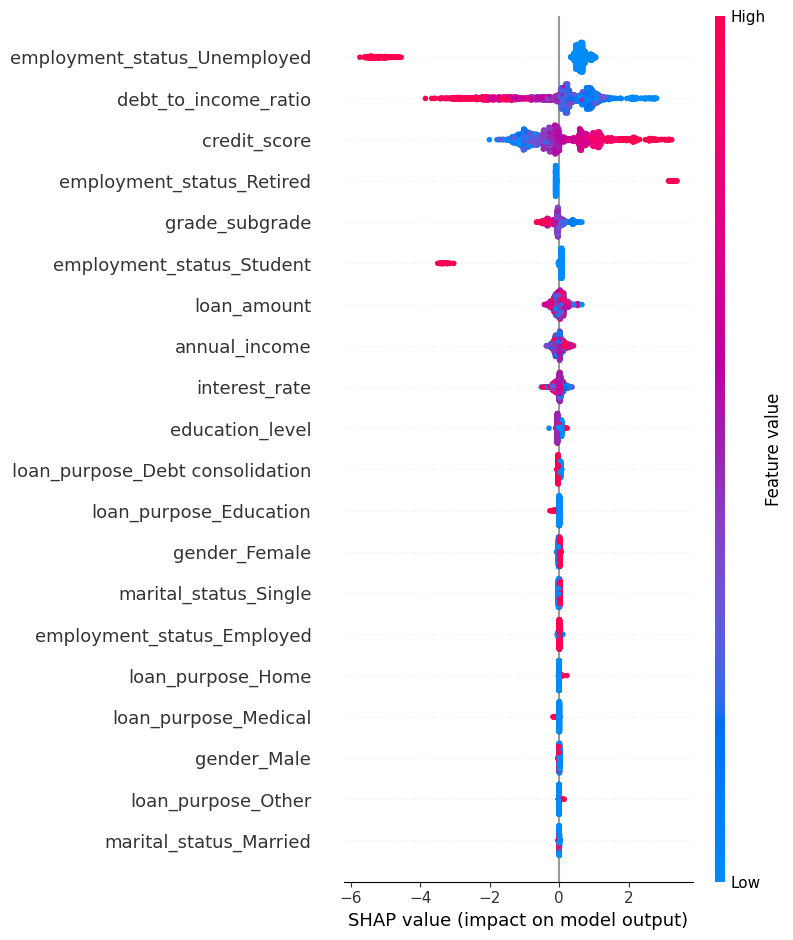

In [37]:
# Kütüphaneyi yükle (Eğer yoksa)
# !pip install shap

import shap
import pandas as pd
import matplotlib.pyplot as plt

# JS görselleştirmelerini notebook'ta aktif et
shap.initjs()

# 1. Örneklem Alma (Sampling)
# Tüm test setini değil, rastgele 1000-2000 satırı alıyoruz.
# Bu kadarı genel trendi görmek için istatistiksel olarak yeterlidir.
# X_test_last numpy array olduğu için sütun isimlerini geri eklememiz lazım (Okunabilirlik için şart)

# feature_names listesinin elinde olduğunu varsayıyorum (önceki adımlardan)
# Eğer yoksa: feature_names = df_train_processed.drop(columns=['id', 'loan_paid_back']).columns.tolist()

X_shap_sample = pd.DataFrame(X_test_last, columns=feature_names).sample(n=2000, random_state=42)

# 2. Explainer Oluşturma (Ağaç Tabanlı Modeller İçin TreeExplainer)
# TreeExplainer, CatBoost/XGBoost gibi modeller için optimize edilmiştir.
explainer = shap.TreeExplainer(model_last)

# 3. SHAP Değerlerini Hesapla
print("⏳ SHAP değerleri hesaplanıyor (Biraz sürebilir)...")
shap_values = explainer.shap_values(X_shap_sample)

# 4. Görselleştirme: Summary Plot (En Bilgi Dolu Grafik)
print("📊 SHAP Summary Plot (Beeswarm):")
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_shap_sample, plot_type="dot") # "dot" veya "bar"

# 5. Alternatif: Sadece Bar Grafiği (Mutlak Önem)
# plt.figure()
# shap.summary_plot(shap_values, X_shap_sample, plot_type="bar")

In [40]:
import joblib
import json
import os

# 1. Kayıt Klasörü
artifact_dir = "/kaggle/working/model_artifacts"
os.makedirs(artifact_dir, exist_ok=True)

print(f"'{artifact_dir}' klasörü hazırlandı.")

# CatBoost'un kendi .save_model() metodu da var
model_path = os.path.join(artifact_dir, "final_catboost_model.pkl")
joblib.dump(model_sub, model_path)
print(f"Model kaydedildi: {model_path}")

# 2. Sütun Sırasını Kaydet (Schema)
# Reindex işlemi için buna MECBURUZ.

cols_path = os.path.join(artifact_dir, "features.json")
with open(cols_path, "w") as f:
    json.dump(train_cols, f)
print(f"Feature listesi kaydedildi ({len(train_cols)} adet): {cols_path}")

# 3. Mapping Sözlüklerini Kaydet (Metadata)


mappings = {
    "education_map": education_map_dic,
    "grade_map": grade_map_dic
}

mapping_path = os.path.join(artifact_dir, "mappings.json")
with open(mapping_path, "w") as f:
    json.dump(mappings, f, indent=4)
print(f"Mapping kuralları kaydedildi: {mapping_path}")

# 4. Konfigürasyon (Threshold)

config = {
    "threshold": 0.7079,
    "model_version": "v1.0.0",
    "algorithm": "CatBoost"
}

config_path = os.path.join(artifact_dir, "config.json")
with open(config_path, "w") as f:
    json.dump(config, f, indent=4)
print(f"Model konfigürasyonu kaydedildi: {config_path}")


'/kaggle/working/model_artifacts' klasörü hazırlandı.
Model kaydedildi: /kaggle/working/model_artifacts/final_catboost_model.pkl
Feature listesi kaydedildi (27 adet): /kaggle/working/model_artifacts/features.json
Mapping kuralları kaydedildi: /kaggle/working/model_artifacts/mappings.json
Model konfigürasyonu kaydedildi: /kaggle/working/model_artifacts/config.json
